In [26]:
import jaxgym.components as comp
from jaxgym.ray import Ray
from jaxgym.run import run_to_end, calculate_derivatives
from jaxgym.taylor import poly_dict, order_indices, poly_dict_to_sympy_expr

import tqdm

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
%matplotlib widget

import sympy as sp
import os

import optax
from optax import apply_updates

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_LIMIT_MB"] = "400"

In [27]:
def adjust_phase(wave):
    center_pixel = (wave.shape[0] // 2, wave.shape[1] // 2)
    phase_shift = jnp.angle(wave[center_pixel])
    adjusted_wave = wave * jnp.exp(-1j * phase_shift)
    return adjusted_wave

def compute_phase(r, wavelength):
    """Compute the phase factor for a given path length array and wavelength."""
    phase = jnp.mod((2 * jnp.pi / wavelength) * r, 2 * jnp.pi) + jnp.pi
    return jnp.exp(1j * phase)

def compute_amplitude_spherical(Z, r, wavelength):
    """Compute the amplitude for a spherical wave."""
    return ((wavelength * 1j)) * (1 / r ** 2)

def phase_error_mask_fn(wave1, wave2, threshold=1e-1):
    phase_error = jnp.abs(jnp.angle(wave1) - jnp.angle(wave2))
    phase_error = jnp.where(phase_error > jnp.pi, 2 * jnp.pi - phase_error, phase_error)
    return (phase_error < threshold).astype(jnp.float64)

def amplitude_error_mask_fn(wave1, wave2, threshold=1e-3):
    amplitude_error = jnp.abs(jnp.abs(wave1) - jnp.abs(wave2))
    return (amplitude_error < threshold).astype(jnp.float64)



In [28]:
z_init = jnp.array(0.0)
z_image = jnp.array(10.0)

image_array = jnp.zeros((11, 11), jnp.complex128)
image_array = image_array.at[5, 5].set(1.0+0.0j)

wavelength = 1e-3
wavenumber = 2 * jnp.pi / wavelength

PointSourcePlane = comp.ImageGrid(z=z_init, image_array=image_array, image_pixel_size=(1e-8, 1e-8), image_shape=(10, 10), image_rotation=0.0)
Detector = comp.Detector(z=z_image, det_pixel_size=(5e-3, 5e-3), det_shape = (257, 257))
model = [PointSourcePlane, Detector]

n_rays = Detector.det_shape[0] * Detector.det_shape[1]

Polyak SGD:   0%|          | 0/1000 [00:00<?, ?it/s]

Polyak SGD:   2%|▏         | 20/1000 [00:17<14:26,  1.13it/s] 


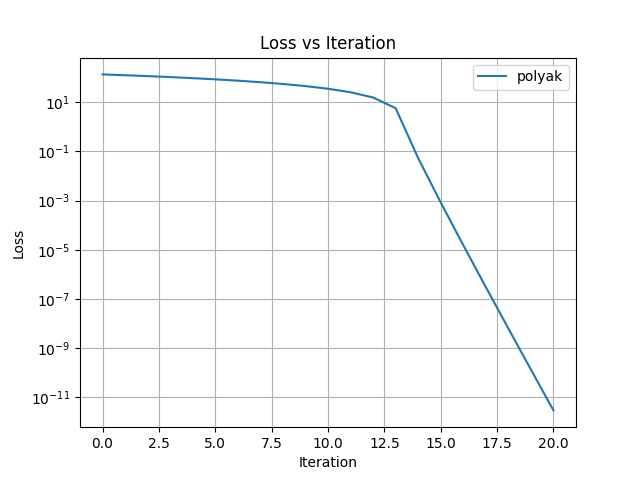

In [47]:
def run_to_end_matrix_wrapper(ray_matrix):
    
    ray = Ray(x=ray_matrix[0],
              y=ray_matrix[1],
              dx=ray_matrix[2],
              dy=ray_matrix[3],
              z=PointSourcePlane.z,
              pathlength=0.0,
              _one=1.0)
    
    ray = run_to_end(ray, model)

    ray_matrix_out = jnp.array([ray.x, ray.y, ray.dx, ray.dy]).T
    return ray_matrix_out, ray.pathlength


def loss(tilts, positions, det_coords):

    tilts_x, tilts_y = tilts[:, 0], tilts[:, 1]
    positions_x, positions_y = positions[:, 0], positions[:, 1]

    ray_matrix = jnp.array([positions_x, positions_y, tilts_x, tilts_y]).T
    ray_matrix_out, _ = jax.vmap(run_to_end_matrix_wrapper)(ray_matrix)

    det_rays_x, det_rays_y, _, _ = ray_matrix_out.T
    
    rays_at_end = jnp.array([det_rays_x, det_rays_y]).T
    error = jnp.linalg.norm(det_coords - rays_at_end) 

    return error

det_coords = Detector.get_coords()
cur_tilts = jnp.zeros((det_coords.shape[0], 2))
cur_positions = jnp.zeros((det_coords.shape[0], 2))

results = {}
max_iterations = 1000
loss_val = 1.0

# Run adam until the loss goes below 1e-2, then switch to lbfgs for fine-tuning.
cur_tilts = jnp.zeros((det_coords.shape[0], 2))
loss_history = []

polyak_opt = optax.polyak_sgd(max_learning_rate=1e-1)
polyak_state = polyak_opt.init(cur_tilts)

def polyak_step(cur_tilts, polyak_state, cur_positions, det_coords):
    loss_val, grads = jax.value_and_grad(loss, argnums=0)(cur_tilts, cur_positions, det_coords)
    updates, polyak_state = polyak_opt.update(grads, polyak_state, params=cur_tilts, value=loss_val)
    cur_tilts = apply_updates(cur_tilts, updates)
    return cur_tilts, polyak_state, loss_val

for i in tqdm.trange(max_iterations, desc="Polyak SGD"):
    cur_tilts, polyak_state, loss_val = polyak_step(cur_tilts, polyak_state, cur_positions, det_coords)
    loss_history.append(loss_val)
    if loss_val < 1e-10:
        break

results["polyak"] = loss_history


plt.figure()
for opt_name, history in results.items():
    plt.plot(history, label=opt_name)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss vs Iteration')
plt.legend()
plt.grid(True)
plt.show()


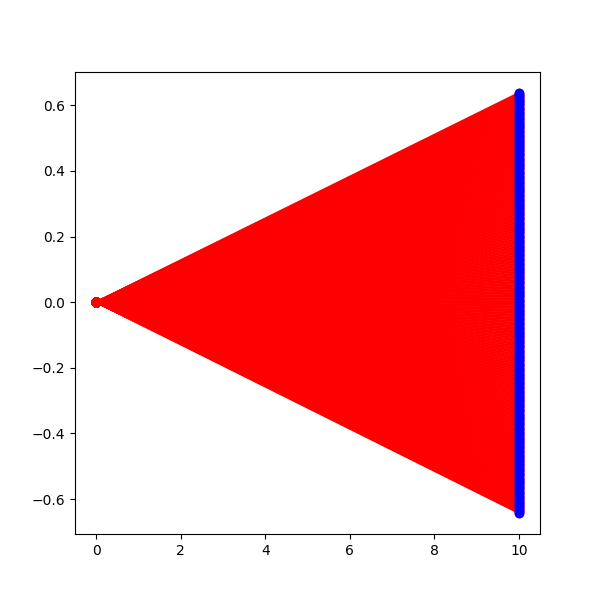

In [39]:
import math

cur_positions_x = cur_positions[:, 0]
cur_positions_y = cur_positions[:, 1]

ray_matrix = jnp.array([cur_positions_x, cur_positions_y, cur_tilts[:, 0], cur_tilts[:, 1]]).T
ray_matrix_out, ray_pathlength = jax.vmap(run_to_end_matrix_wrapper)(ray_matrix)
ray_det_x, ray_det_y, _, _ = ray_matrix_out.T

#2D plot
plt.figure(figsize=(6, 6))
num_to_plot = int(math.sqrt(n_rays))
plt.plot([PointSourcePlane.z, Detector.z], [cur_positions_x[:num_to_plot], ray_det_x[:num_to_plot]], 'ro-')
plt.plot(jnp.ones(len(det_coords[:num_to_plot, 0])) * Detector.z, det_coords[:num_to_plot, 0], 'bo')
plt.show()


In [40]:
ray_matrix = jnp.array([cur_positions_x, cur_positions_y, cur_tilts[:, 0], cur_tilts[:, 1]]).T
jacobian_fn = jax.jacobian(run_to_end_matrix_wrapper, argnums=0)
ray_jac = jax.vmap(jacobian_fn)(ray_matrix)
B = ray_jac[0][:, :2, 2:4]

dx, dy = Detector.det_pixel_size
amplitude = jnp.sqrt(jnp.linalg.det(B)) * wavelength
amplitude = amplitude.reshape(Detector.det_shape[0], Detector.det_shape[1])
amplitude /= jnp.max(amplitude)
phase = jnp.mod(ray_pathlength * wavenumber, 2 * jnp.pi) + jnp.pi
phase = phase.reshape(Detector.det_shape[0], Detector.det_shape[1])

jac_wave = amplitude * jnp.exp(1j * phase)
jac_wave = adjust_phase(jac_wave)

In [41]:
detector_coords_xy = Detector.get_coords()
det_y = detector_coords_xy[:, 0]
det_x = detector_coords_xy[:, 1]

Z = Detector.z - PointSourcePlane.z

r = jnp.sqrt(det_x**2 + det_y**2 + Z**2)
phase = compute_phase(r, wavelength)
amplitude = 1/r**2 #compute_amplitude_spherical(Z, r, wavelength)

amplitude /= jnp.max(amplitude)

ampltude = jnp.sqrt(jnp.abs(amplitude))
spherical_wave = amplitude * phase
spherical_wave = spherical_wave.reshape(*Detector.det_shape)
spherical_wave = adjust_phase(spherical_wave)

/tmp/ipykernel_1417283/3967121999.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2, 4, figsize=(12, 8), constrained_layout=True)


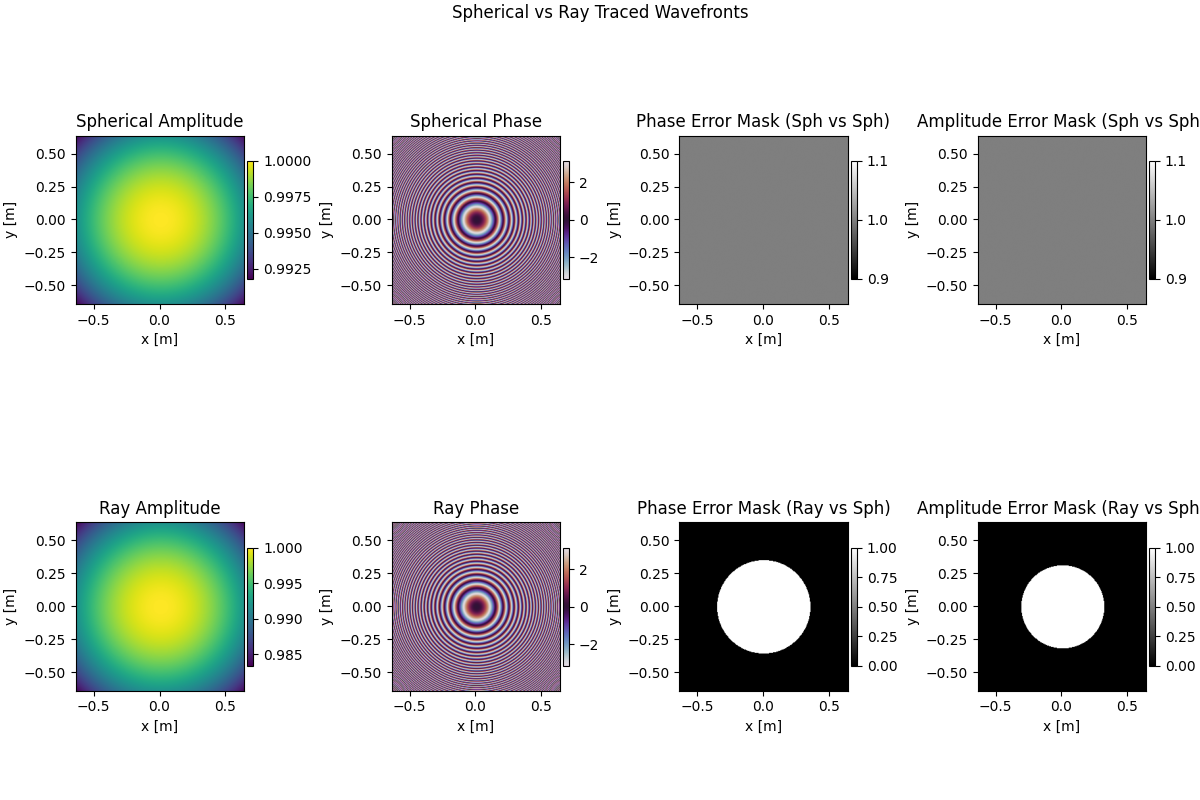

In [42]:
# Spherical vs Spherical (should be all 1s)
phase_error_mask_sph = phase_error_mask_fn(spherical_wave, spherical_wave)
amplitude_error_mask_sph = amplitude_error_mask_fn(spherical_wave, spherical_wave)

# Spherical vs Jac
phase_error_mask_jac = phase_error_mask_fn(spherical_wave, jac_wave)
amplitude_error_mask_jac = amplitude_error_mask_fn(spherical_wave, jac_wave)

fig, ax = plt.subplots(2, 4, figsize=(12, 8), constrained_layout=True)
plt.suptitle('Spherical vs Ray Traced Wavefronts', fontsize=12)

# Row 1: Spherical
im0 = ax[0, 0].imshow(jnp.abs(spherical_wave), extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()))
ax[0, 0].set_title('Spherical Amplitude')
ax[0, 0].set_xlabel('x [m]')
ax[0, 0].set_ylabel('y [m]')
fig.colorbar(im0, ax=ax[0, 0], fraction=0.035, pad=0.02)

im1 = ax[0, 1].imshow(jnp.angle(spherical_wave), extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()), cmap='twilight')
ax[0, 1].set_title('Spherical Phase')
ax[0, 1].set_xlabel('x [m]')
ax[0, 1].set_ylabel('y [m]')
fig.colorbar(im1, ax=ax[0, 1], fraction=0.035, pad=0.02)

im2 = ax[0, 2].imshow(phase_error_mask_sph, extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()), cmap='gray')
ax[0, 2].set_title('Phase Error Mask (Sph vs Sph)')
ax[0, 2].set_xlabel('x [m]')
ax[0, 2].set_ylabel('y [m]')
fig.colorbar(im2, ax=ax[0, 2], fraction=0.035, pad=0.02)

im3 = ax[0, 3].imshow(amplitude_error_mask_sph, extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()), cmap='gray')
ax[0, 3].set_title('Amplitude Error Mask (Sph vs Sph)')
ax[0, 3].set_xlabel('x [m]')
ax[0, 3].set_ylabel('y [m]')
fig.colorbar(im3, ax=ax[0, 3], fraction=0.035, pad=0.02)

# Row 2: Jac
im4 = ax[1, 0].imshow(jnp.abs(jac_wave), extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()))
ax[1, 0].set_title('Ray Amplitude')
ax[1, 0].set_xlabel('x [m]')
ax[1, 0].set_ylabel('y [m]')
fig.colorbar(im4, ax=ax[1, 0], fraction=0.035, pad=0.02)

im5 = ax[1, 1].imshow(jnp.angle(jac_wave), extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()), cmap='twilight')
ax[1, 1].set_title('Ray Phase')
ax[1, 1].set_xlabel('x [m]')
ax[1, 1].set_ylabel('y [m]')
fig.colorbar(im5, ax=ax[1, 1], fraction=0.035, pad=0.02)

im6 = ax[1, 2].imshow(phase_error_mask_jac, extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()), cmap='gray')
ax[1, 2].set_title('Phase Error Mask (Ray vs Sph)')
ax[1, 2].set_xlabel('x [m]')
ax[1, 2].set_ylabel('y [m]')
fig.colorbar(im6, ax=ax[1, 2], fraction=0.035, pad=0.02)

im7 = ax[1, 3].imshow(amplitude_error_mask_jac, extent=(det_x.min(), det_x.max(), det_y.min(), det_y.max()), cmap='gray')
ax[1, 3].set_title('Amplitude Error Mask (Ray vs Sph)')
ax[1, 3].set_xlabel('x [m]')
ax[1, 3].set_ylabel('y [m]')
fig.colorbar(im7, ax=ax[1, 3], fraction=0.035, pad=0.02)



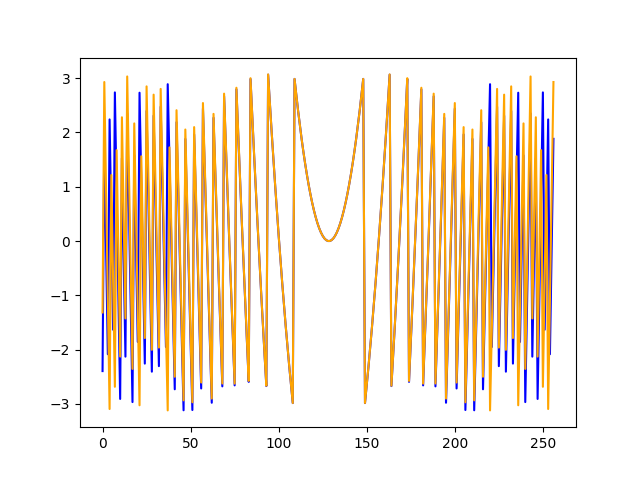

In [34]:
# plot the 1D cross section in the centre of ray phase and spherical phase

plt.figure()
plt.plot(jnp.angle(spherical_wave[:, 128]), label='Spherical Amplitude', color='blue') 
plt.plot(jnp.angle(jac_wave[:, 128]), label='Ray Amplitude', color='orange')